# Lecture 6: Least squares approximation of functions

Today we will turn from _interpolation_ to _fitting_: finding a good approximation of an unknown function from a collection of pointwise evaluations, without requiring that our approximation exactly matches (i.e., interpolates) these evaluations. Sometimes this process is called "smoothing," although that term is more commonly used for kernel-based approaches (which we'll discuss next week). From a statistical perspective, the problem we will solve can be understood as _parametric linear regression_.

## Outline of the lecture:
- Least squares polynomial approximation
- The normal equations
- Experiments:
  - Noisy function evaluations: from overfitting to smoothing
  - Using _many_ points and few basis functions
  - Choice of nodal set/regression points; condition number of the design matrix
- Least squares approximation with arbitrary basis functions
- Polynomials revisited: orthogonal polynomial bases 

## Pitfalls of interpolation
Consider fitting to some noisy data (example from FNC): 5-year averages of the worldwide temperature anomaly, compared to the 1951-1980 average

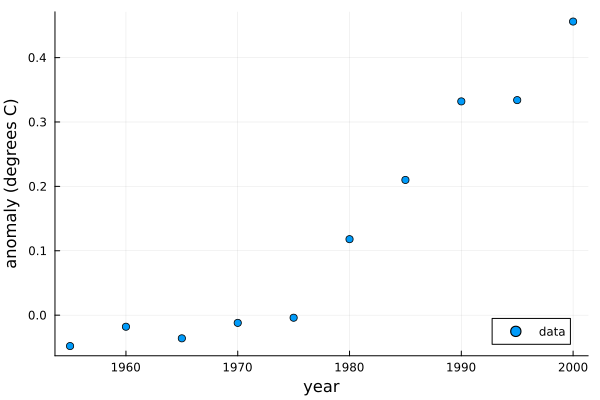

In [20]:
using Plots, LaTeXStrings, LinearAlgebra
year = 1955:5:2000
temp = [ -0.0480, -0.0180, -0.0360, -0.0120, -0.0040,
       0.1180, 0.2100, 0.3320, 0.3340, 0.4560 ]
    
scatter(year, temp, label="data",
    xlabel="year", ylabel="anomaly (degrees C)", 
    legend=:bottomright)

Now fit this with a polynomial. **Note: we don't get to pick the nodal set!**

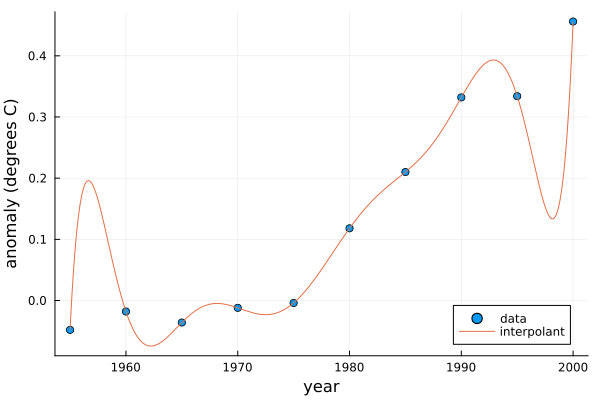

In [21]:
t = @. (year - 1950) / 10               # shift to improve condition number of vdM matrix
n = length(t)
V = [ t[i]^j for i in 1:n, j in 0:n-1 ] # polynomial will be of degree n-1
c = V \ temp                            # solve for poly coefficients

using Polynomials
p = Polynomial(c)
f = yr -> p((yr - 1950) / 10)
plot!(f, 1955, 2000, label="interpolant")

Overfitting! Sadness. How can we do a better job?

**On the board:** constructing a least-squares fit.

In [62]:
t = @. (year - 1950) / 10  
degree = 3;
V = [ t[i]^j for i in 1:length(t), j in 0:degree ]   
@show size(V);

size(V) = (10, 4)


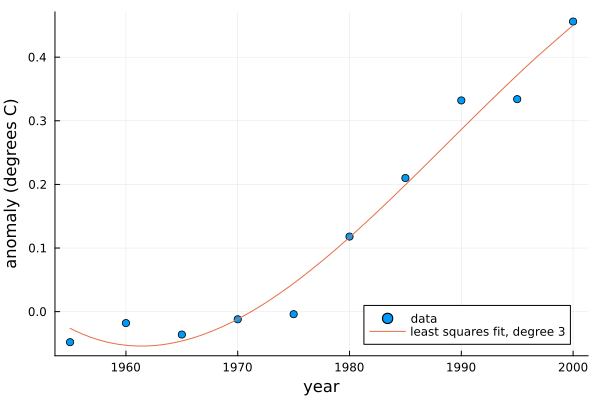

In [63]:
p = Polynomial( V \ temp ) # Solve the normal equations

f = yr -> p((yr - 1950) / 10)
scatter(year, temp, label="data",
    xlabel="year", ylabel="anomaly (degrees C)", leg=:bottomright)
plot!(f, 1955, 2000, label="least squares fit, degree $degree")

In [35]:
cond(V)

6.453137998680762e8

In [36]:
cond(V' * V)

4.178728366313566e17

Aside: the backslash operator does _not_ directly solve $V^\top V c = V^\top y$. Note the squaring of the condition number above. Rather it computes a factorization of $V$, e.g., a $QR$ factorization. We will talk about this next week.

Let's bring back some of our functions from last time

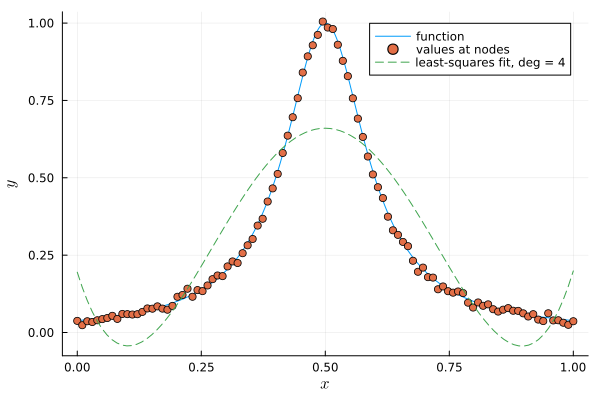

In [73]:
using Random, BasicInterpolators
# Random.seed!(1234)

# f = x -> abs(exp(sin(7x)) - 1 ) # Discontinuous derivatives
# f = x -> exp(sin(7x))           # Entire function
f = x -> 1 / (1 + 100(x - 0.5)^2) # Runge function
# f = x -> ( x < 0.5 ? 0.0 : (x > 0.5 ? 1.0 : 0.5) )  # Heaviside function
plot(f, 0, 1, label="function", xlabel=L"x", ylabel=L"y")

M = 100;                 # number of regression points (N on the blackboard)
t = range(0,1,M)       # choose a uniform grid
# t = chebygrid(0, 1, M)   # or Chebyshev (not so useful here!)
# t = rand(M)            # or sample at random from Unif(0,1)

# Can also add noise to the function evaluations!
y = f.(t)  + 1e-2 * randn(length(t))

degree = 4;               # polynomial degree (m-1 on the blackboard)
V = t .^ (0:degree)'      # the Vandermonde matrix
c = V \ y
p = Polynomial(c)

scatter!(t, y, label="values at nodes")
plot!(p, 0, 1, linestyle=:dash, label="least-squares fit, deg = $degree")

In [60]:
size(V)

(100, 7)

# General basis functions

We are not restricted to using polynomials in a least squares approximation. In fact, we can use any (linearly independent) collection of basis functions $(\phi_i)_{i=1}^m$.

Return to temperature data example

c = [-0.9830176080967193, 0.9200597325559221, -0.9058838747161363]


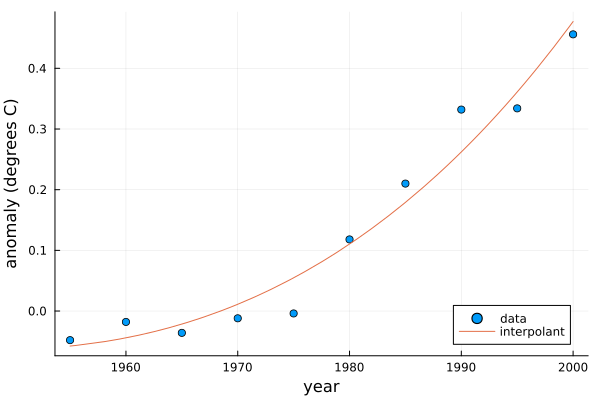

In [79]:
year = 1955:5:2000
temp = [ -0.0480, -0.0180, -0.0360, -0.0120, -0.0040,
       0.1180, 0.2100, 0.3320, 0.3340, 0.4560 ]
    
scatter(year, temp, label="data",
    xlabel="year", ylabel="anomaly (degrees C)", 
    legend=:bottomright)

t = @. (year - 1950) / 55               # shift and scale
n = length(t)

phi1 = x -> 1;
phi2 = x -> exp(x);
phi3 = x -> x;

V = [ phi1.(t) phi2.(t) phi3.(t) ]  
c = V \ temp                        # solve for poly coefficients
@show c

scatter(year, temp, label="data",
    xlabel="year", ylabel="anomaly (degrees C)", 
    legend=:bottomright)

pfit = x -> c[1] .* phi1(x) + c[2] .* phi2(x)  + c[3] .* phi3(x)
pfitscaled = yr -> pfit((yr - 1950) / 55)
plot!(pfitscaled, 1955, 2000, label="interpolant")


Along these lines: if you are going to do least-squares polynomial fitting, it is far better to use a basis of _orthogonal polynomials_ than it is to use the _monomial_ basis. Let's try the Legendre polynomials, orthogonal with respect to uniform weight 

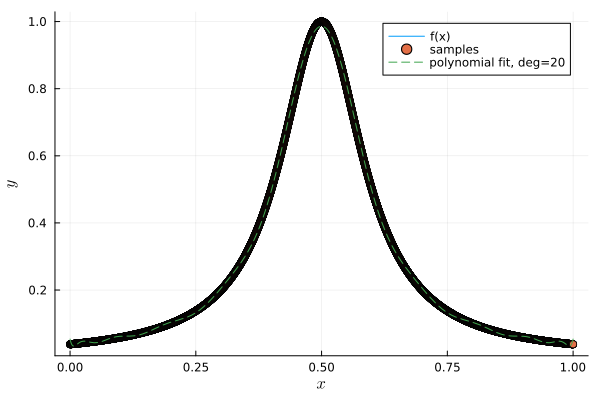

In [105]:
using ClassicalOrthogonalPolynomials   # provides legendrep(n, x)

f = x -> 1 / (1 + 100(x - 0.5)^2) # Runge function

# sample points in [0,1]
M = 10000
t = collect(range(0, 1; length=M))
# t = rand(M)            # or sample at random from Unif(0,1)
y = f.(t)

degree = 20   # poly degree

# build orthonormal Legendre Vandermonde on [0,1]
# phi_n(t) = sqrt(2n+1) * P_n(2t-1)
function legendre_matrix(tvec::AbstractVector, degree::Integer)
    N = length(tvec)
    V = zeros(Float64, N, degree+1)
    svec = 2 .* tvec .- 1   # mapped points in [-1,1]
    for n in 0:degree
        # evaluate P_n(s) at all svec (vectorized)
        # ClassicalOrthogonalPolynomials provides legendrep(n, x)
        V[:, n+1] = sqrt(2n + 1) .* legendrep.(n, svec)
    end
    return V
end

Vorth = legendre_matrix(t, degree)   # size M × (degree+1)

# Solve normal equations
c = Vorth \ y  

# build evaluator for the fitted expansion p(t) = sum_{n=0}^degree a[n+1]*phi_n(t)
p_leg(tval) = begin
    s = 2tval - 1
    Pvals = [legendrep(n, s) for n in 0:degree]
    return sum(c[n+1] * sqrt(2n + 1) * Pvals[n+1] for n in 0:degree)
end


# Plot function and fit
plot(f, 0, 1, label="f(x)", xlabel=L"x", ylabel=L"y")
scatter!(t, y, label="samples")
plot!(x -> p_leg(x), 0, 1, linestyle=:dash, label="polynomial fit, deg=$degree")

In [106]:
cond(Vorth)

1.0115728687910956

Observe that $V^\top V$ built from orthonormal polynomials is almost diagonal

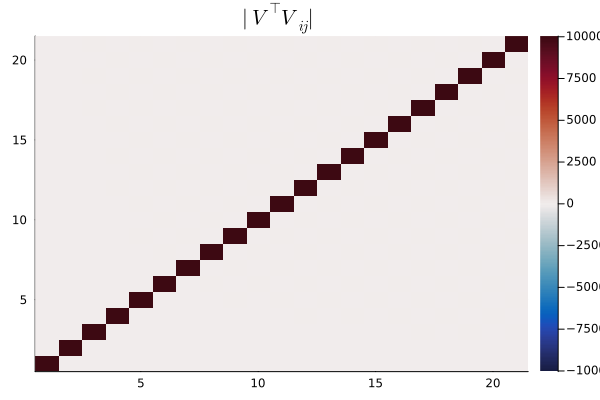

In [113]:
almosteye = Vorth' * Vorth;

# heatmap of matrix, centering colormap
m = maximum(abs, almosteye)
heatmap(almosteye,
    colormap=:balance,   # or :coolwarm, :RdBu, :viridis etc
    clims = (-m, m),
    colorbar=true,
    title = L"|V^\top V_{ij}|"
)
